# Lab 4 - Linear models

We focus on models in the form 

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$



In [16]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [17]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


## Task 1. Prior predictive checks

In [18]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

sim.summary()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,0.0,NaN,0.000000e+00,0.0,0.0,0.0,NaN,NaN,NaN
mu,140.0,NaN,9.700000e-13,140.0,140.0,140.0,NaN,NaN,NaN
sigma,2.5,NaN,3.600000e-15,2.5,2.5,2.5,NaN,NaN,NaN
mu_pred,170.0,0.32,1.000000e+01,150.0,170.0,190.0,990.0,49000.0,1.0
sigma_pred,15.0,0.16,5.000000e+00,6.1,15.0,23.0,1000.0,50000.0,1.0
height_pred,170.0,0.63,1.900000e+01,140.0,170.0,200.0,910.0,45000.0,1.0


   lp__  accept_stat__       mu    sigma  mu_pred  sigma_pred  height_pred
0   0.0            0.0  144.933  2.45943  165.755    14.68170      147.076
1   0.0            0.0  144.933  2.45943  171.276     8.05289      173.258
2   0.0            0.0  144.933  2.45943  181.987    26.32670      207.546
3   0.0            0.0  144.933  2.45943  175.554    17.99470      175.157
4   0.0            0.0  144.933  2.45943  183.120    13.28940      178.986


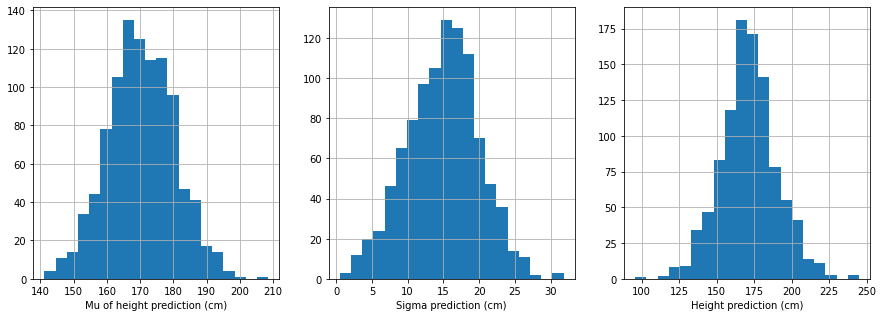

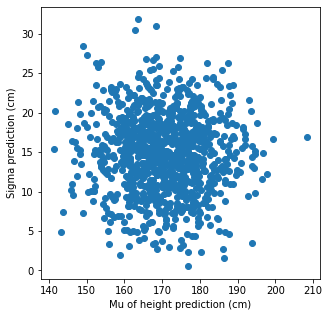

In [19]:
mu_pred = sim.stan_variable('mu_pred')
sigma_pred = sim.stan_variable('sigma_pred')
height_pred = sim.stan_variable('height_pred')

df = sim.draws_pd() # convert to dataframe
print(df.head())

# 1. Plot histograms of mu, sigma and simulated height.
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
df['mu_pred'].hist(ax=axs[0], bins=20)
axs[0].set_xlabel('Mu of height prediction (cm)')
df['sigma_pred'].hist(ax=axs[1], bins=20)
axs[1].set_xlabel('Sigma prediction (cm)')
df['height_pred'].hist(ax=axs[2], bins=20)
axs[2].set_xlabel('Height prediction (cm)')
plt.show()

# 2. Plot a joint distribution of mu and sigma.
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(df['mu_pred'], df['sigma_pred'])
ax.set_xlabel('Mu of height prediction (cm)')
ax.set_ylabel('Sigma prediction (cm)')
plt.show()

Mean mu:  170.35 cm
Prior mu:  170.00 cm


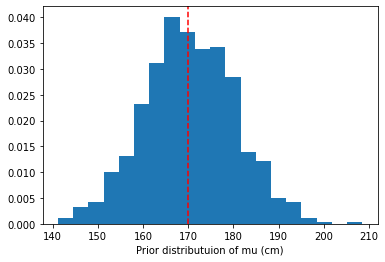

Mean sigma:  14.91 cm
Prior sigma:  15.00 cm


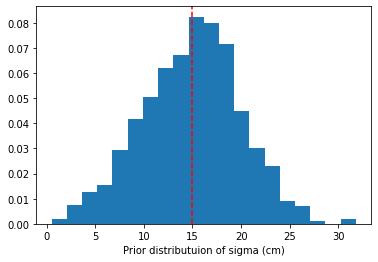

Mean height:  171.47 cm


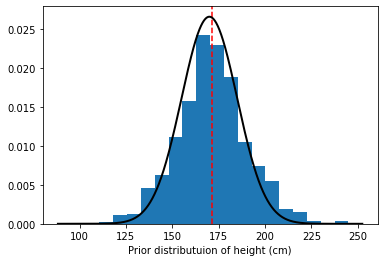

Percent of observed height samples within +/- 1 sigma:  61.00 %
Percent of observed height samples within +/- 2 sigma:  87.80 %
Percent of observed height samples within +/- 3 sigma:  97.40 %


In [20]:
from scipy.stats import norm
# 3. Check if samples are consistent with priors.
# 4. Correct prior parameters to make them reasonably spreaded out.
prior_mu = 170
mean_mu = df['mu_pred'].mean()
print("Mean mu: ", "{:.2f}".format(mean_mu), "cm")
print("Prior mu: ", "{:.2f}".format(prior_mu), "cm")

plt.hist(df['mu_pred'], bins=20, density=True)
plt.xlabel('Prior distributuion of mu (cm)')
plt.axvline(x=prior_mu, color='r', linestyle='--')
plt.show()

prior_sigma = 15
mean_sigma = df['sigma_pred'].mean()
print("Mean sigma: ", "{:.2f}".format(mean_sigma), "cm")
print("Prior sigma: ", "{:.2f}".format(prior_sigma), "cm")

plt.hist(df['sigma_pred'], bins=20, density=True)
plt.xlabel('Prior distributuion of sigma (cm)')
plt.axvline(x=prior_sigma, color='r', linestyle='--')
plt.show()

mean_height = df['height_pred'].mean()
print("Mean height: ", "{:.2f}".format(mean_height), "cm")

plt.hist(df['height_pred'], bins=20, density=True)
plt.xlabel('Prior distributuion of height (cm)')
plt.axvline(x=mean_height, color='r', linestyle='--')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, prior_mu, prior_sigma)
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')
plt.show()

# 5. Check if observed data is possible to obtain using priors.
percent_sigma_1 = len(df[(df['height_pred'] >= prior_mu - prior_sigma) & (df['height_pred'] <= prior_mu + prior_sigma)]) / len(df)
print("Percent of observed height samples within +/- 1 sigma: ", "{:.2f}".format(percent_sigma_1 * 100), "%")

percent_sigma_2 = len(df[(df['height_pred'] >= prior_mu - 2 * prior_sigma) & (df['height_pred'] <= prior_mu + 2 * prior_sigma)]) / len(df)
print("Percent of observed height samples within +/- 2 sigma: ", "{:.2f}".format(percent_sigma_2 * 100), "%")

percent_sigma_3 = len(df[(df['height_pred'] >= prior_mu - 3 * prior_sigma) & (df['height_pred'] <= prior_mu + 3 * prior_sigma)]) / len(df)
print("Percent of observed height samples within +/- 3 sigma: ", "{:.2f}".format(percent_sigma_3 * 100), "%")



1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors.
4. Correct prior parameters to make them reasonably spreaded out. 
5. Check if observed data is possible to obtain using priors.

## Task 2. Model fit and evaluation

In [21]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')
fit=model_1_fit.sample(data=dict(N=len(d), heights=d.height.values), 
                       chains=1,
                       seed=28052020)

fit.summary()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-890.0,0.052,1.00,-900.0,-890.0,-890.0,410.0,9100.0,1.0
mu,150.0,0.013,0.41,150.0,150.0,160.0,940.0,21000.0,1.0
sigma,7.8,0.011,0.30,7.3,7.8,8.3,820.0,18000.0,1.0
height_fit,150.0,0.240,7.80,140.0,150.0,170.0,1100.0,23000.0,1.0



1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.

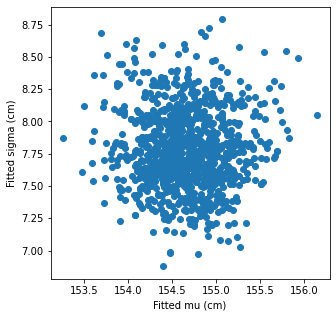

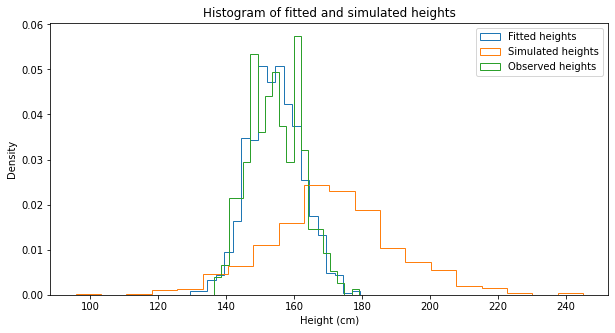

In [22]:
# 1. Plot a joint distribution of fitted mu and sigma.
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(fit.stan_variable('mu'), fit.stan_variable('sigma'))
ax.set_xlabel('Fitted mu (cm)')
ax.set_ylabel('Fitted sigma (cm)')
plt.show()

# 2. Plot histograms of data and simulated heights and evaluate the quality of model.
plt.figure(figsize=(10, 5))
plt.title('Histogram of fitted and simulated heights')
plt.hist(fit.stan_variable('height_fit'), bins=20, density=True, label='Fitted heights', histtype='step')
plt.hist(sim.stan_variable('height_pred'), bins=20, density=True, label='Simulated heights', histtype='step')
plt.hist(d.height, bins=20, density=True, label='Observed heights', histtype='step')
plt.legend(loc='upper right')
plt.xlabel('Height (cm)')
plt.ylabel('Density')
plt.show()


## Task 3. Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [23]:
d['c_weight']=d.weight-d.weight.mean()

data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}

## Task 4. Prior predictive checks
 

In [24]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

pd_sim = sim.draws_pd()
sim.summary()

INFO:cmdstanpy:compiling stan file /usr/data-analytics-lectures/Data Analytics/Lab 4/height_2a_ppc.stan to exe file /usr/data-analytics-lectures/Data Analytics/Lab 4/height_2a_ppc
INFO:cmdstanpy:compiled model executable: /usr/data-analytics-lectures/Data Analytics/Lab 4/height_2a_ppc
--- Translating Stan model to C++ code ---
bin/stanc  --o=/tmp/tmpx4m5l6pf/tmpu27y9wmi.hpp /tmp/tmpx4m5l6pf/tmpu27y9wmi.stan
Warning in '/tmp/tmpx4m5l6pf/tmpu27y9wmi.stan', line 3, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/tmpx4m5l6pf/tmpu27y9wmi.stan', line 10, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically us

chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,0.000,NaN,0.0,0.00,0.000,0.0,NaN,NaN,NaN
alpha_pred,160.000,0.320,10.0,140.00,150.000,170.0,990.0,13000.0,1.0
beta_pred,0.031,0.035,1.0,-1.70,-0.027,1.7,850.0,11000.0,1.0
sigma_pred,2.700,0.083,2.7,0.13,1.900,8.3,1100.0,14000.0,1.0
height_pred[1],155.000,0.570,18.0,127.00,154.000,184.0,938.0,12182.0,1.0
height_pred[2],155.000,0.560,17.0,128.00,155.000,183.0,950.0,12336.0,1.0
height_pred[3],155.000,0.550,16.0,128.00,155.000,182.0,883.0,11468.0,1.0
height_pred[4],155.000,0.530,16.0,129.00,155.000,181.0,936.0,12158.0,1.0
height_pred[5],155.000,0.520,16.0,129.00,155.000,180.0,905.0,11759.0,1.0


Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

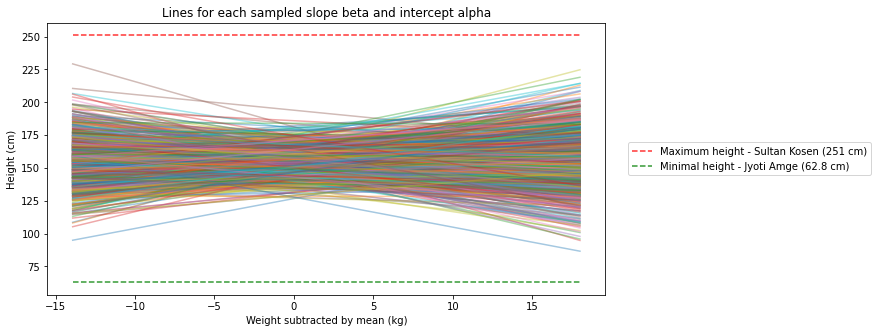

In [25]:
tallest_man_alive = 251 # (cm) Sultan Kosen
shortest_man_alive = 62.8 # (cm) Jyoti Amge

# 1. Plot lines for each sampled slope beta and intercept alpha.
plt.figure(figsize=(10, 5))
plt.title('Lines for each sampled slope beta and intercept alpha')
for alpha, beta in zip(sim.stan_variable('alpha_pred'), sim.stan_variable('beta_pred')):
    y = alpha + beta * data_sim['weight']
    plt.plot(data_sim['weight'], y, alpha=0.4)
plt.xlabel('Weight subtracted by mean (kg)')
plt.ylabel('Height (cm)')

# 2. Verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
x_line = np.linspace(data_sim['weight'].min(), data_sim['weight'].max())
y_line = np.linspace(tallest_man_alive, tallest_man_alive)
plt.plot(x_line, y_line, alpha=0.8, color='red', linestyle='--', label="Maximum height - Sultan Kosen (251 cm)")
y_line = np.linspace(shortest_man_alive, shortest_man_alive)
plt.plot(x_line, y_line, alpha=0.8, color='green', linestyle='--', label="Minimal height - Jyoti Amge (62.8 cm)")
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.show()

## Task 5. Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [26]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:compiling stan file /usr/data-analytics-lectures/Data Analytics/Lab 4/height_2b_ppc.stan to exe file /usr/data-analytics-lectures/Data Analytics/Lab 4/height_2b_ppc
INFO:cmdstanpy:compiled model executable: /usr/data-analytics-lectures/Data Analytics/Lab 4/height_2b_ppc
--- Translating Stan model to C++ code ---
bin/stanc  --o=/tmp/tmpl5qnpnr0/tmp94ka8lif.hpp /tmp/tmpl5qnpnr0/tmp94ka8lif.stan
Warning in '/tmp/tmpl5qnpnr0/tmp94ka8lif.stan', line 3, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/tmpl5qnpnr0/tmp94ka8lif.stan', line 10, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically us

In [27]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

sim.summary()

pd_sim = sim.draws_pd()

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each simulated height plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated height (all in the same plot). Compare with observed data. Is observed data possible within the prior model?


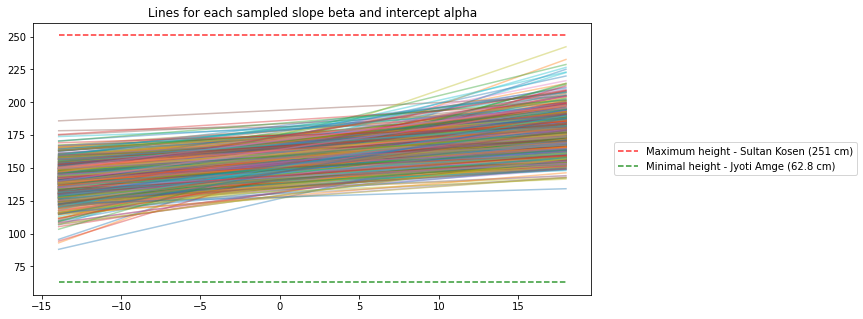

In [28]:
# 1a. Plot lines for each sampled slope beta and intercept alpha.
plt.figure(figsize=(10, 5))
plt.title('Lines for each sampled slope beta and intercept alpha')
for alpha, beta in zip(sim.stan_variable('alpha_pred'), sim.stan_variable('beta_pred')):
    y = alpha + beta * data_sim['weight']
    plt.plot(data_sim['weight'], y, alpha=0.4)

# 1b. Verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
x_line = np.linspace(data_sim['weight'].min(), data_sim['weight'].max())
y_line = np.linspace(tallest_man_alive, tallest_man_alive)
plt.plot(x_line, y_line, alpha=0.8, color='red', linestyle='--', label="Maximum height - Sultan Kosen (251 cm)")
y_line = np.linspace(shortest_man_alive, shortest_man_alive)
plt.plot(x_line, y_line, alpha=0.8, color='green', linestyle='--', label="Minimal height - Jyoti Amge (62.8 cm)")
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.show()

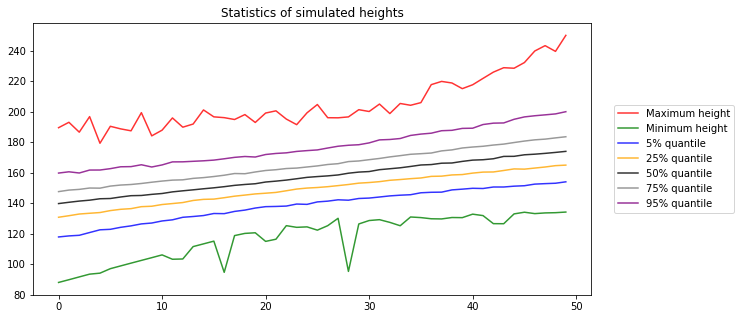

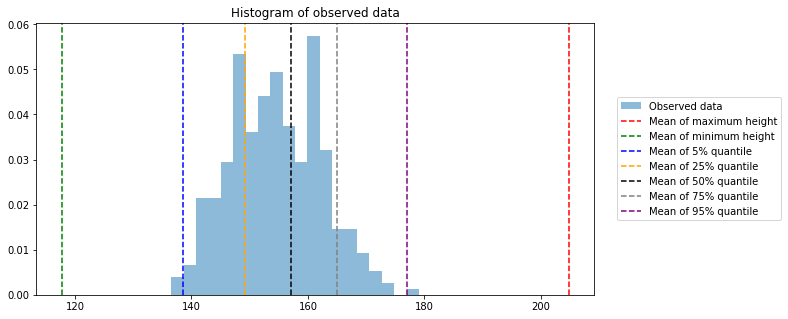

In [29]:
# 2a. For each simulated height plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated height (all in the same plot). 
max = np.zeros(len(sim.stan_variable('height_pred')[0]))
min = np.zeros(len(sim.stan_variable('height_pred')[0]))
q5 = np.zeros(len(sim.stan_variable('height_pred')[0]))
q25 = np.zeros(len(sim.stan_variable('height_pred')[0]))
q50 = np.zeros(len(sim.stan_variable('height_pred')[0]))
q75 = np.zeros(len(sim.stan_variable('height_pred')[0]))
q95 = np.zeros(len(sim.stan_variable('height_pred')[0]))

for i in range(len(sim.stan_variable('height_pred')[0])):
    max[i] = np.max(sim.stan_variable('height_pred')[:, i])
    min[i] = np.min(sim.stan_variable('height_pred')[:, i])
    q5[i] = np.quantile(sim.stan_variable('height_pred')[:, i], 0.05)
    q25[i] = np.quantile(sim.stan_variable('height_pred')[:, i], 0.25)
    q50[i] = np.quantile(sim.stan_variable('height_pred')[:, i], 0.50)
    q75[i] = np.quantile(sim.stan_variable('height_pred')[:, i], 0.75)
    q95[i] = np.quantile(sim.stan_variable('height_pred')[:, i], 0.95)

plt.figure(figsize=(10, 5))
plt.title('Statistics of simulated heights')
plt.plot(max, alpha=0.8, color='red', label="Maximum height")
plt.plot(min, alpha=0.8, color='green', label="Minimum height")
plt.plot(q5, alpha=0.8, color='blue', label="5% quantile")
plt.plot( q25, alpha=0.8, color='orange', label="25% quantile")
plt.plot(q50, alpha=0.8, color='black', label="50% quantile")
plt.plot(q75, alpha=0.8, color='gray', label="75% quantile")
plt.plot(q95, alpha=0.8, color='purple', label="95% quantile")
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.show()

# 2b. Compare with observed data. Is observed data possible within the prior model?
mean_max = np.mean(max)
mean_min = np.mean(min)
mean_q5 = np.mean(q5)
mean_q25 = np.mean(q25)
mean_q50 = np.mean(q50)
mean_q75 = np.mean(q75)
mean_q95 = np.mean(q95)

# Plot observed data on histogram and vertiacal line to see if it is possible within the prior model.
plt.figure(figsize=(10, 5))
plt.title('Histogram of observed data')
plt.hist(d.height, bins=20, density=True, alpha=0.5, label="Observed data")
plt.axvline(mean_max, color='red', linestyle='--', label="Mean of maximum height")
plt.axvline(mean_min, color='green', linestyle='--', label="Mean of minimum height")
plt.axvline(mean_q5, color='blue', linestyle='--', label="Mean of 5% quantile")
plt.axvline(mean_q25, color='orange', linestyle='--', label="Mean of 25% quantile")
plt.axvline(mean_q50, color='black', linestyle='--', label="Mean of 50% quantile")
plt.axvline(mean_q75, color='gray', linestyle='--', label="Mean of 75% quantile")
plt.axvline(mean_q95, color='purple', linestyle='--', label="Mean of 95% quantile")
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.show()


Most of the data are withing 5% quantile to 95% quantile and none of the observed data are lower then minimum and maximum height from the prior predictive check model so the conclusion is that observed data are possible to obtain with this prior model.


## Task 6. Fitting and evaluating model


In [30]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:compiling stan file /usr/data-analytics-lectures/Data Analytics/Lab 4/height_2_fit.stan to exe file /usr/data-analytics-lectures/Data Analytics/Lab 4/height_2_fit
INFO:cmdstanpy:compiled model executable: /usr/data-analytics-lectures/Data Analytics/Lab 4/height_2_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/tmp/tmp97b3_zev/tmp0mdso7fz.hpp /tmp/tmp97b3_zev/tmp0mdso7fz.stan
Warning in '/tmp/tmp97b3_zev/tmp0mdso7fz.stan', line 3, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/tmp97b3_zev/tmp0mdso7fz.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using 

1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe

In [31]:
# 1. Create data_fit dictionary containing data from N first rows of dataframe
N = 10
df_N = d.head(N)
data_fit = {'N': N, 'weight': df_N.weight, 'height': df_N.height}

fit=model_2_fit.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


2. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each value of weight plot mean simulated height along with errorbar of one standard deviation (use ```errorbar``` from matplotlib). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


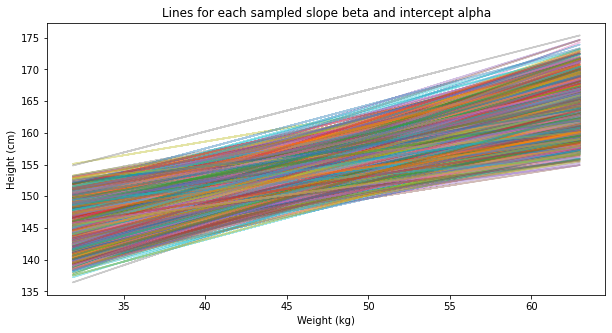

In [32]:
# 2a. Plot lines for each sampled slope beta and intercept alpha.
plt.figure(figsize=(10, 5))
plt.title('Lines for each sampled slope beta and intercept alpha')
for alpha, beta in zip(fit.stan_variable('alpha'), fit.stan_variable('beta')):
    y = alpha + beta * df_N['weight']
    plt.plot(df_N['weight'], y, alpha=0.4)
plt.xlabel('Weight (kg)')
plt.ylabel('Height (cm)')
plt.show()


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


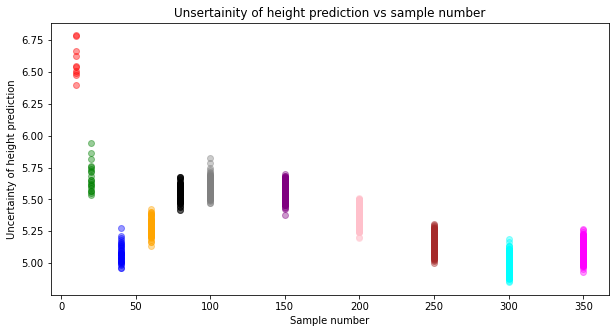

In [33]:
# 2b. Verify how uncertainity changes with increasing of sample (N)
N_list = {
    'numbers': [10, 20, 40, 60, 80, 100, 150, 200, 250, 300, 350],
    'colors': ['red', 'green', 'blue', 'orange', 'black', 'gray', 'purple', 'pink', 'brown', 'cyan', 'magenta']
}

plt.figure(figsize=(10, 5))
plt.title('Unsertainity of height prediction vs sample number')
for index, N in enumerate(N_list['numbers']):
    df_N = d.head(N)
    data_fit = {'N': N, 'weight': df_N.weight, 'height': df_N.height}
    fit=model_2_fit.sample(data=data_fit,seed=28052020)
    uncertainty_std = np.std(fit.stan_variable('height_fit'), axis=0)
    for i in range(len(uncertainty_std)):
        plt.plot(N, uncertainty_std[i], 'o', alpha=0.4, color = N_list['colors'][index])
plt.xlabel('Sample number')
plt.ylabel('Uncertainty of height prediction')
plt.show()

The plot shows that:
1. Unsertianity of height predictions is the highest for the lowest sample number.
2. Unsertianity decreases with increasing of sample number with the lowest value for the 40 first samples.
3. After 40 samples, uncertainty slightly increases with increasing of sample number  up to the 100 first samples, and then it decreases again.

Summarizing the general trend is that uncertainty decreases with increasing of sample number.

## Task 7. Extending the model

1. Center the weight data (substract mean vaule of weight from all values). Test how model works for such data. What is the interpretation of $\alpha$ in such case?
2. Using centered data modify your model with a second power of weight, select prior for its coefficient using prior predictive checks and after fitting check if model is still good.
3. Try to vectorize the model to avoid necessity of a for loop in the ```model``` block. 

In [34]:
N = len(d)
df_N = d.head(N)
# 1a. Center the weight data (substract mean vaule of weight from all values). 
center_weight = df_N.weight - np.mean(df_N.weight)

data_fit = {'N': N, 'weight': center_weight, 'height': df_N.height}

fit=model_2_fit.sample(data=data_fit,seed=28052020)


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


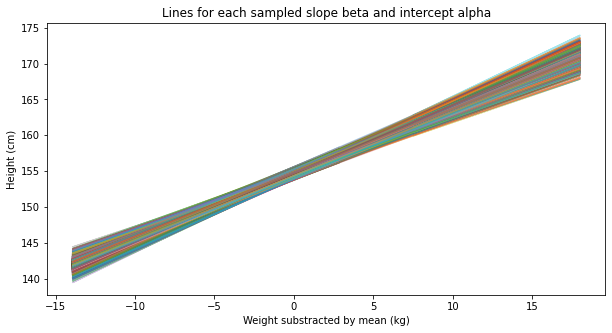

In [36]:
# 1b. Test how model works for such data. What is the interpretation of $\alpha$ in such case?
plt.figure(figsize=(10, 5))
plt.title('Lines for each sampled slope beta and intercept alpha')
for alpha, beta in zip(fit.stan_variable('alpha'), fit.stan_variable('beta')):
    y = alpha + beta * center_weight
    plt.plot(center_weight, y, alpha=0.4)
plt.xlabel('Weight substracted by mean (kg)')
plt.ylabel('Height (cm)')
plt.show()

Alpha in that case is the mean height for the mean centered weight (weight substracted by mean weight).

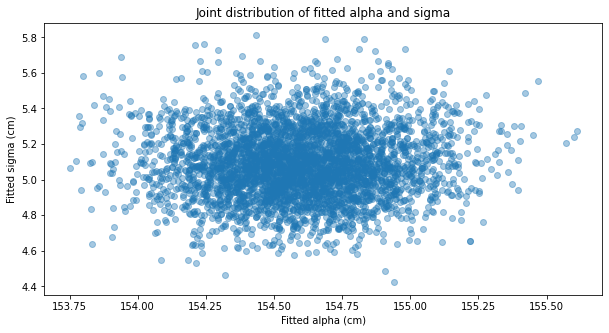

In [37]:
# Plot a joint distribution of fitted alpha and sigma.
plt.figure(figsize=(10, 5)) 
plt.title('Joint distribution of fitted alpha and sigma')
plt.scatter(fit.stan_variable('alpha'), fit.stan_variable('sigma'), alpha=0.4)
plt.xlabel('Fitted alpha (cm)')
plt.ylabel('Fitted sigma (cm)')
plt.show()